# **Dataset & Description**



[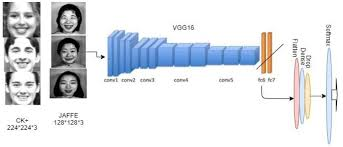](http://)


The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.








[Dataset link ](https://www.kaggle.com/msambare/fer2013)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
torch.manual_seed(10)

In [2]:
class EyeDiseaseClassicationImageDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = datasets.ImageFolder(root=root_dir, transform=transform)
        self.classes = self.dataset.classes

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]


In [3]:
root_directory = '/kaggle/input/'

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = (224, 224)),
    transforms.RandomRotation(degrees=5),
    transforms.RandomHorizontalFlip(p=0.5),
])

dataset = EyeDiseaseClassicationImageDataset(root_dir='/kaggle/input/dataset', transform=data_transform)

In [4]:
DEVICE = 'cuda:0'

In [5]:
# split data into train, val and test datasets
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(len(dataset)*0.9), len(dataset) - int(len(dataset)*0.9)])
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [int(len(train_dataset)*0.8), len(train_dataset) - int(len(train_dataset)*0.8)])

In [6]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")

Train dataset size: 3036
Test dataset size: 422
Val dataset size: 759


In [7]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
sample_img, sample_lbl = next(iter(train_loader))
print(f"Image batch shape: {sample_img.size()}")
print(f"Label batch shape: {sample_lbl.size()}")

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Image batch shape: torch.Size([64, 3, 224, 224])
Label batch shape: torch.Size([64])


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


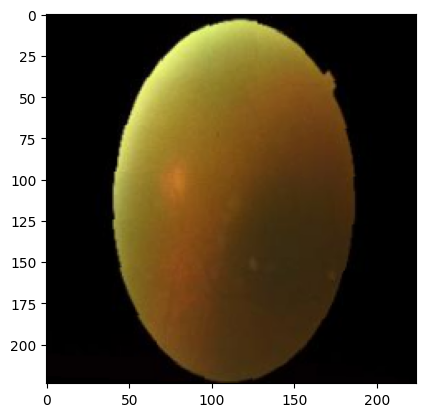

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io
import cv2
img = train_dataset[3][0]
imgplot = plt.imshow(img.permute(1,2,0))
plt.show()

# Model

In [9]:
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights, vgg19, VGG19_Weights
import torch.nn as nn
import tqdm

In [10]:
model = vgg19(weights = VGG19_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 275MB/s]


In [11]:
# freeze all the layers of VGG
for param in model.parameters():
    param.requires_grad = False 

In [12]:
# modify the classifier layer
model.classifier = nn.Sequential(*list(model.classifier.children())[:-1], nn.Linear(4096, 1024), nn.ReLU(), nn.Linear(1024,4))

In [13]:
ct = 0
for child in model.features:
    ct += 1
    if ct > 27:
        for param in child.parameters():
            param.requires_grad = True

In [14]:
# allow learning only for the linear layer
for param in model.classifier.parameters():
    param.requires_grad = True 

In [15]:
model = model.to(DEVICE)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [16]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
def evaluate(model, data_loader, criterion):
    """Evaluate the model on the given dataset."""
    # Set the model to evaluation mode.
    model.eval()
    correct = 0
    val_loss = 0
    count = 0
    # The `torch.no_grad()` context will turn off gradients for efficiency.
    with torch.no_grad():
        for images, labels in (data_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            output = model(images)
            pred = output.argmax(dim=1)
            loss = criterion(output, labels)
            correct += (pred == labels).sum().item()
            val_loss += loss.item()
            
            count += 1
    val_losses.append(val_loss/count)
    return correct / len(data_loader.dataset), val_loss/count


def train(model, n_epoch, optimizer, scheduler):
    """Train the model on the given dataset."""
    loss_ref = float('inf')
    for epoch in range(n_epoch):
        # Set the model to training mode.
        correct = 0
        model.train()
        for step, (images, labels) in enumerate(train_loader):
            # 0. Prepare the data. Move the data to the device (CPU/GPU).
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            # 1. Clear previous gradients.
            optimizer.zero_grad()
            # 2. Forward pass. Calculate the output of the model.
            output = model(images)
            pred = output.argmax(dim=1)
            correct += (pred==labels).sum().item()
            # 3. Calculate the loss.
            loss = criterion(output, labels)
            # 4. Calculate the gradients. PyTorch does this for us!
            loss.backward()
            # 5. Update the model parameters.
            optimizer.step()
            if step % 5 == 0:
                print(f"Epoch {epoch}, Step {step}, Loss {loss.item():.4f}")
        
        train_acc = correct/len(train_loader.dataset)
        train_losses.append(loss.cpu().detach().numpy())
        acc, val_loss = evaluate(model, valid_loader, criterion)
        scheduler.step(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(acc)
        print(f"Epoch {epoch}, Valid Accuracy {acc * 100:.2f}%, Train Accuracy {train_acc * 100:.2f}%, Val loss {val_loss}")  # Train the model for 10 epochs.
        
        if val_loss < loss_ref:
            patience = 5
            loss_ref = val_loss
        else:
            if patience == 0:
                print(f"[Early Stopping] Epoch {epoch}, Valid Accuracy {acc * 100:.2f}%, Valid Loss {val_loss:.4f}")
                return
            print(f"[INFO] Patience {patience} remaining")
            patience-=1


In [17]:
lr = 1e-3
gamma = 0.9
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

n_epoch = 100
train(model, n_epoch, optimizer, scheduler)

Epoch 0, Step 0, Loss 1.3925
Epoch 0, Step 5, Loss 1.2730
Epoch 0, Step 10, Loss 1.3882
Epoch 0, Step 15, Loss 1.3897
Epoch 0, Step 20, Loss 1.3557
Epoch 0, Step 25, Loss 1.3185
Epoch 0, Step 30, Loss 1.0994
Epoch 0, Step 35, Loss 1.3370
Epoch 0, Step 40, Loss 1.1246
Epoch 0, Step 45, Loss 1.0013
Epoch 0, Valid Accuracy 62.32%, Train Accuracy 36.26%, Val loss 0.8799762229124705
Epoch 1, Step 0, Loss 0.9511
Epoch 1, Step 5, Loss 0.8401
Epoch 1, Step 10, Loss 1.1086
Epoch 1, Step 15, Loss 0.9621
Epoch 1, Step 20, Loss 1.0000
Epoch 1, Step 25, Loss 0.6064
Epoch 1, Step 30, Loss 0.7700
Epoch 1, Step 35, Loss 0.6673
Epoch 1, Step 40, Loss 0.7734
Epoch 1, Step 45, Loss 0.6858
Epoch 1, Valid Accuracy 76.94%, Train Accuracy 64.86%, Val loss 0.6141709138949712
Epoch 2, Step 0, Loss 0.7273
Epoch 2, Step 5, Loss 0.6243
Epoch 2, Step 10, Loss 0.8422
Epoch 2, Step 15, Loss 0.7309
Epoch 2, Step 20, Loss 0.7826
Epoch 2, Step 25, Loss 0.6013
Epoch 2, Step 30, Loss 0.7460
Epoch 2, Step 35, Loss 0.6113


In [18]:
def test(model, data_loader):
    """Evaluate the model on the given dataset."""
    # Set the model to evaluation mode.
    model.eval()
    correct = 0
    
    all_labels = []
    all_preds = []

    # The `torch.no_grad()` context will turn off gradients for efficiency.
    with torch.no_grad():
        for images, labels in (data_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            output = model(images)
            pred = output.argmax(dim=1)
            correct += (pred == labels).sum().item()
            all_labels.extend([x.cpu().detach() for x in labels])
            all_preds.extend([x.cpu().detach() for x in pred])

    return correct / len(data_loader.dataset), all_labels, all_preds

In [19]:
test_accuracy, labels, preds = test(model, test_loader)

In [20]:
torch.save(model, '/kaggle/working/vgg_best1.pth')

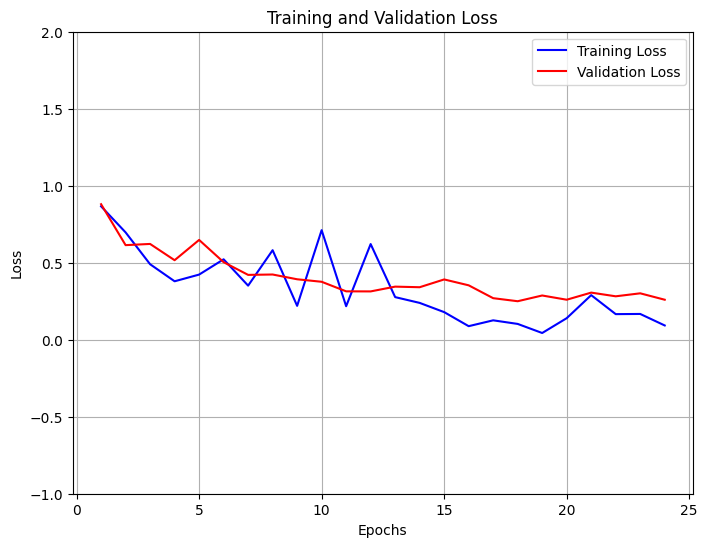

In [21]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

# Plotting
plt.figure(figsize=(8, 6))
plt.ylim([-1,2])
plt.plot(epochs, train_losses, 'b', label='Training Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

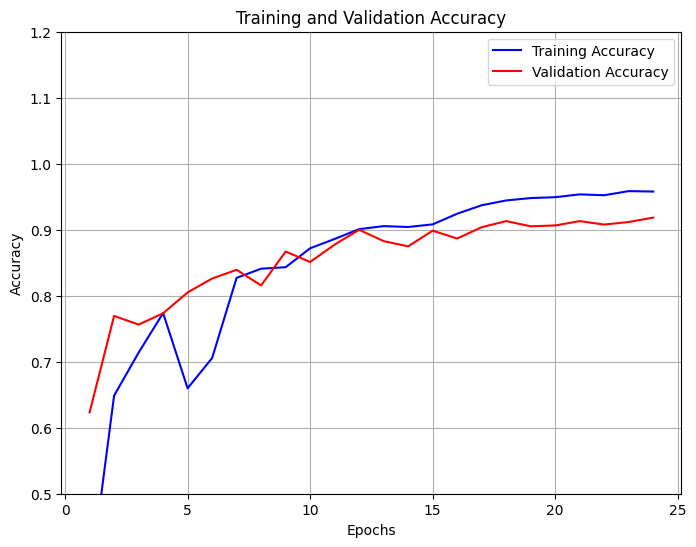

In [22]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_accuracies) + 1)

# Plotting
plt.figure(figsize=(8, 6))
plt.ylim([0.5,1.2])
plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
!pip install torcheval

  Obtaining dependency information for torcheval from https://files.pythonhosted.org/packages/e4/de/e7abc784b00de9d05999657d29187f1f7a3406ed10ecaf164de06482608f/torcheval-0.0.7-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 1.8 MB/s eta 0:00:00


In [24]:
from torcheval.metrics.functional import multiclass_f1_score
multiclass_f1_score(torch.tensor(labels), torch.tensor(preds), num_classes=4)

tensor(0.9171)

In [25]:
print("Test Accuracy: ",test_accuracy)

Test Accuracy:  0.9170616113744076
